In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy import spatial

from utils import sph2cart, remove_hidden_points
from plotting import set_axes_equal, set_defense_context, draw_unit_cube

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# generate coordinates of a sphere

r = 5  # cm
theta = np.linspace(0, 2 * np.pi, 201)
phi = np.linspace(0, np.pi, 99)
Theta, Phi = np.meshgrid(theta, phi)
x, y, z = sph2cart(r, Theta.ravel(), Phi.ravel())
xyz = np.c_[x, y, z]

In [4]:
# create 2 synthetic absorbed power density patterns

mask = np.where(xyz[:, 0] > 0)[0]  # the wave propagates in the x-direction
y = xyz[mask, 1]
z = xyz[mask, 2]

center_1 = [0, 0]
radius_1 = 0.5
region_1 = np.sqrt(((y - center_1[0]) / 1.5) ** 2 + (z - center_1[1]) ** 2)
color_1 = 15.1 * np.exp(-(region_1 / radius_1) ** 2)

center_2 = [2.5, -1]
radius_2 = 1.5
region_2 = np.sqrt((y - center_2[0]) ** 2 + (z - center_2[1]) ** 2)
color_2 = 10 * np.exp(-(region_2 / radius_2) ** 2)

color = np.zeros((xyz.shape[0], ))
color[mask] = color_1 + color_2

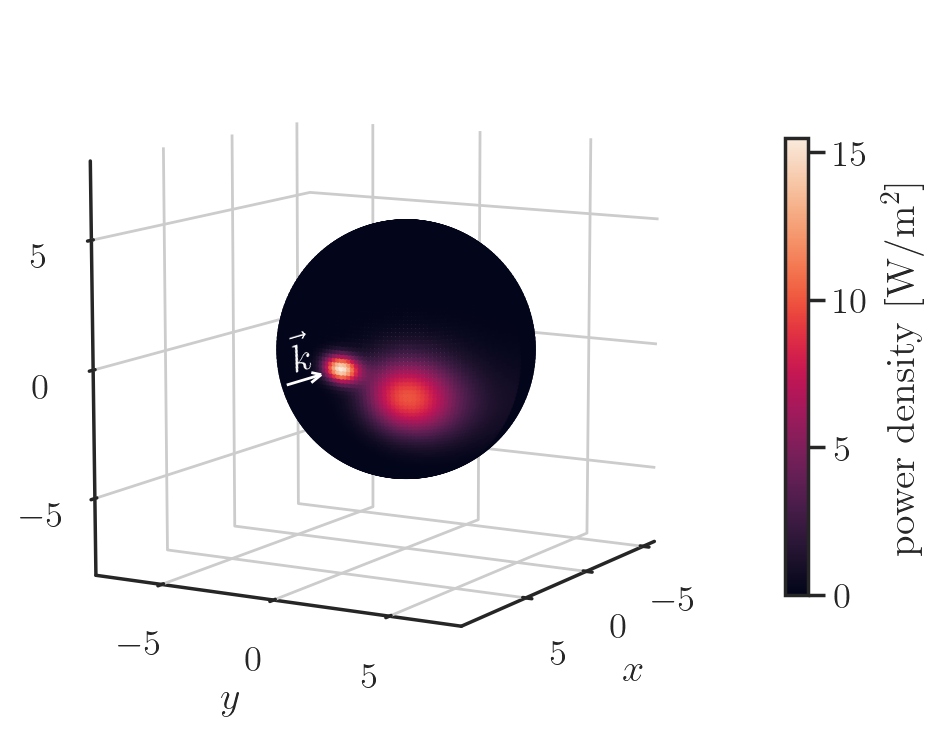

In [25]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz.T, c=color, s=1, depthshade=True)
    ax.quiver(9, 0, 0, -2.5, 0, 0, lw=1, color='w')
    ax.text(9, 0, 0.5, s='$\\vec k$', color='w', zdir='x')
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(10, 30)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    fig.colorbar(s, ax=ax, pad=0.075, shrink=0.5,
                 label='power density [W/m$^2$]')
    fig.tight_layout()
    plt.show()

In [26]:
# extract visible points from the assumed direction of incidence

center = np.mean(xyz, axis=0)
diameter = np.linalg.norm(xyz.max(axis=0) - xyz.min(axis=0))
pov = center.copy()
pov[0] += diameter * 10
mask = remove_hidden_points(xyz, pov, np.pi)

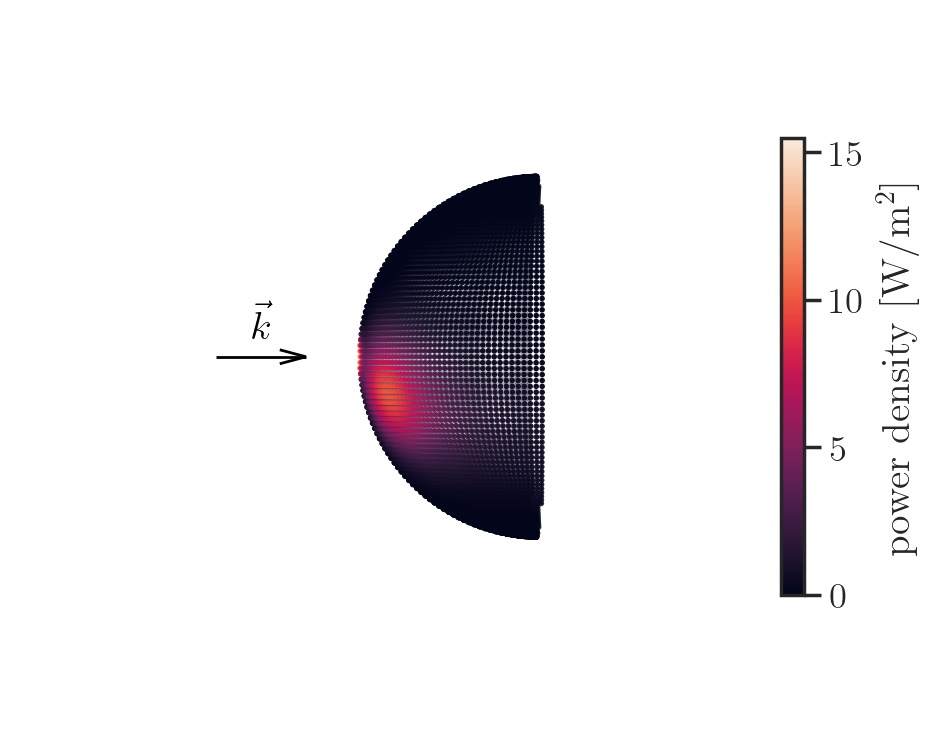

In [27]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz[mask].T, c=color[mask], s=1, depthshade=True)
    ax.quiver(9, 0, 0, -2.5, 0, 0, lw=1, color='k')
    ax.text(8, 0, 0.5, s='$\\vec k$', color='k', zdir='x')
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(0, 90)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.set_axis_off()
    fig.colorbar(s, ax=ax, pad=0.075, shrink=0.5,
                 label='power density [W/m$^2$]')
    fig.tight_layout()
    plt.show()

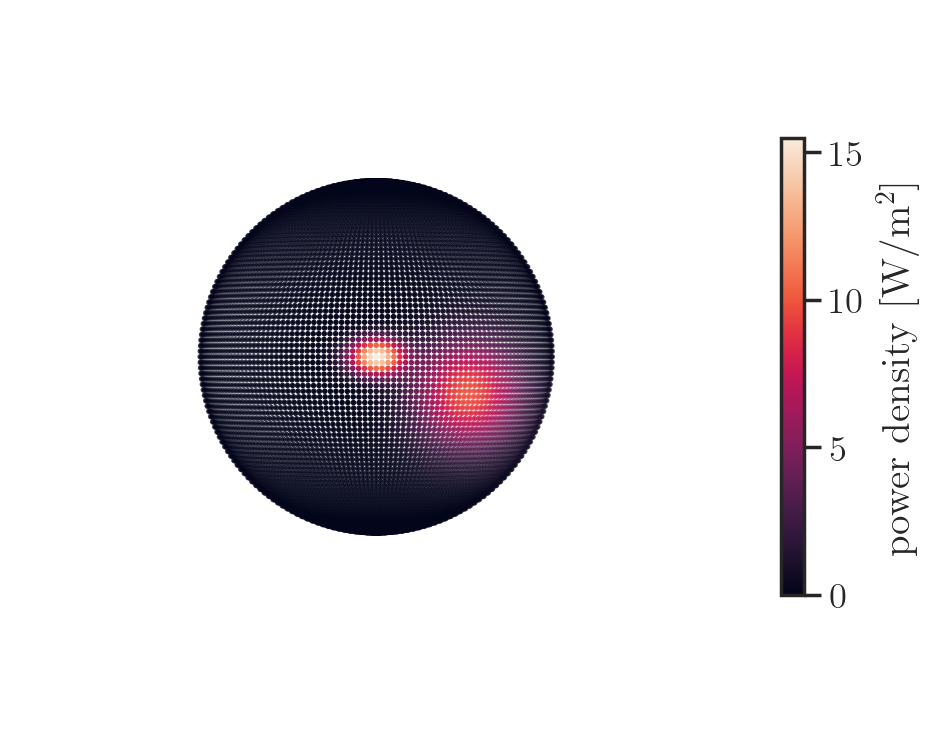

In [ ]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz[mask].T, c=color[mask], s=1, depthshade=True)
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(0, 0)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.set_axis_off()
    fig.colorbar(s, ax=ax, pad=0.075, shrink=0.5,
                 label='power density [W/m$^2$]')
    fig.tight_layout()
    plt.show()

In [123]:
A = 4  # square-shaped surface in cm2
a = np.sqrt(A)
r = np.sqrt(a**2 / 2)

query_point = xyz[np.where(color == color.max())[0][0]]
bbox = [query_point[1]-a/2, query_point[1]+a/2,
        query_point[2]-a/2, query_point[2]+a/2]

tree = spatial.KDTree(xyz)
nbh_idx = tree.query_ball_point([query_point], r)[0]
query_nbh = xyz[nbh_idx]

mask = ((query_nbh[:, 1] > bbox[0])
        & (query_nbh[:, 1] < bbox[1])
        & (query_nbh[:, 2] > bbox[2])
        & (query_nbh[:, 2] < bbox[3]))
query_nbh_bounded = query_nbh[mask]

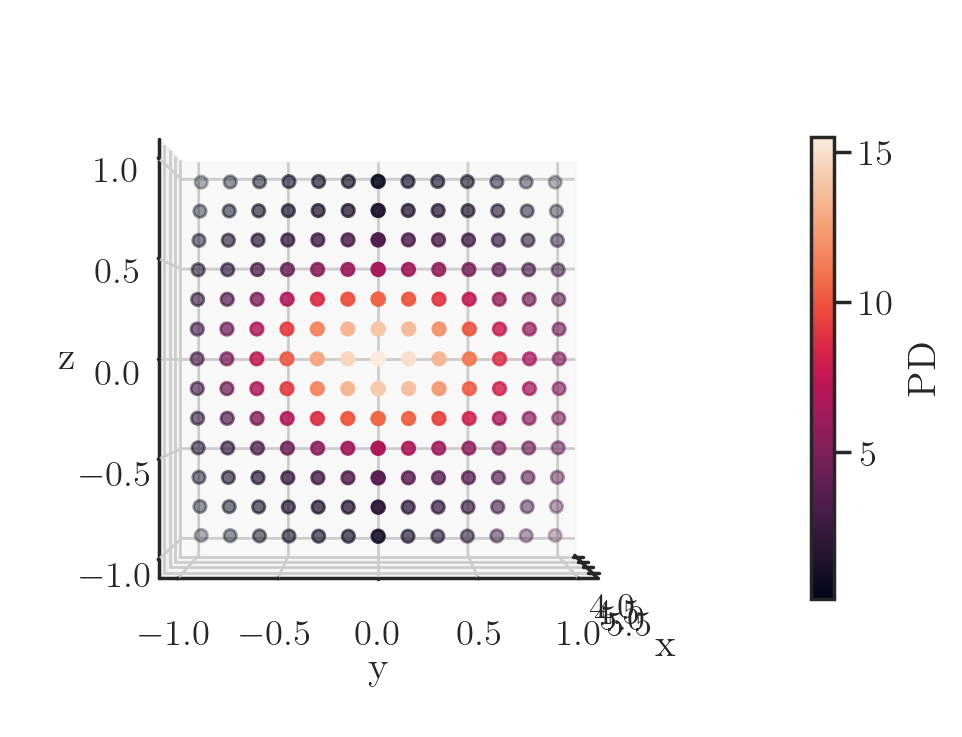

In [125]:
with set_defense_context():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*query_nbh_bounded.T, c=color[nbh_idx][mask])
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    ax.view_init(0, 0)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    fig.colorbar(s, ax=ax, pad=0.1, shrink=0.5, label='PD')
    plt.show()

In [ ]:
# proracunat normale i njihovu duljinu koristeci analiticke izraze
# integrirat normale da bi dobija povrsinu
# integrirat PD da bi dobija APD
# podijelit APD sa stvarnom povrsinom
# napravit iteraciju po svim tockama u kojima ima +-10% tocaka u odnosu na srednji broj susjednih tocaka